In [3]:
from htmd import *
htmd.config(viewer='VMD')
def analysis(sims,boot=0.8,clusters=1000,merge=5):
    metr = Metric(sims)
    metr.projection(MetricDistance('protein and name CA', 'resname MOL and noh', metric='contacts'))
    data = metr.project()
    data.fstep = 0.1
    data.plotTrajSizes()
    print('\n\n\n\n\n')
    data.dropTraj()
    tica = TICA(data, 10)
    dataTica = tica.project(3)
    dataBoot = dataTica.bootstrap(0.8)
    dataBoot.cluster(MiniBatchKMeans(n_clusters=1000), mergesmall=5) #try with dataTica instead of dataBoot
    model = Model(dataBoot) #try with dataTica
    model.plotTimescales() 
    print('\n\n\n\n\n')
    nframes=input('At which time do time scales converge?')
    ntimescales=input('How many different time scales do you see?')
    model.markovModel(int(nframes)*10, int(ntimescales)) 
    mols = model.getStates()

    model.viewStates(ligand='resname MOL and noh')
    kin = Kinetics(model, temperature=298, concentration=0.0037)
    goodmacros=dict()
    mols = model.getStates()
    for i in range(len(mols)):
        for j in range(len(mols)):
            r = kin.getRates(i,j)
            if r.g0eq < -0.2:
                try:
                    goodmacros[i].append(j)
                except:
                    goodmacros[i]=[j]
    
    curr_max_len=0
    for keys in goodmacros:
        if len(goodmacros[keys])>curr_max_len:
            curr_max_len=len(goodmacros[keys])
            thekey=keys

    retlist=list()
    for sinks in goodmacros[thekey]:
        retlist.append(mols[sinks])
    kin.plotRates(rates=('g0eq'))
    print("---")
    kin.plotFluxPathways()    
    return retlist

`%matplotlib` prevents importing * from pylab and numpy
2016-06-30 13:49:45,157 - htmd.simlist - INFO - Starting listing of simulations.


Populating the interactive namespace from numpy and matplotlib



========== Current ligand directory: ./benzamidine_adaptative_sampling/filtered/  ==========

['./benzamidine_adaptative_sampling/filtered/1/', './benzamidine_adaptative_sampling/filtered/2/', './benzamidine_adaptative_sampling/filtered/e2s1_2p0f40/', './benzamidine_adaptative_sampling/filtered/e2s2_2p0f38/', './benzamidine_adaptative_sampling/filtered/e3s1_1p0f2/'] ['./benzamidine_adaptative_sampling/filtered//filtered.pdb']
Creating simlist: 100% (5/5) [#####################################] eta 00:01 |

2016-06-30 13:49:45,162 - htmd.simlist - INFO - Finished listing of simulations.


2016-06-30 13:49:45,366 - htmd.projections.metric - INFO - Metric: Starting projection of trajectories.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1647s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   6 out of   5 | elapsed:    0.2s remaining:   -0.0s
[Parallel(n_jobs=-2)]: Done   6 out of   5 | elapsed:    0.2s remaining:   -0.0s
[Parallel(n_jobs=-2)]: Done   6 out of   5 | elapsed:    0.3s remaining:   -0.1s
[Parallel(n_jobs=-2)]: Done   6 out of   5 | elapsed:    0.3s remaining:   -0.1s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    0.3s finished
2016-06-30 13:49:45,855 - htmd.projections.metric - INFO - Finished projecting the trajectories.
2016-06-30 13:49:45,857 - htmd.projections.metric - INFO - Frame step 0.0ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


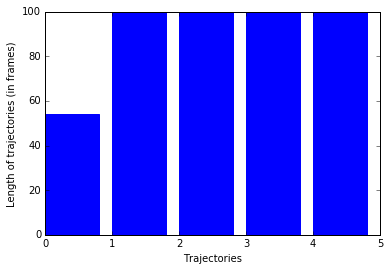

2016-06-30 13:49:46,019 - htmd.metricdata - INFO - Dropped 1 trajectories from 5 resulting in 4


2016-06-30 13:49:47,341 - htmd.simlist - INFO - Starting listing of simulations.



 ########################################################## 

 Trajectories are to small. Starting analysis for next folder.

 ########################################################## 




========== Current ligand directory: ./choline_adaptative_sampling/filtered/  ==========

['./choline_adaptative_sampling/filtered/1/', './choline_adaptative_sampling/filtered/2/', './choline_adaptative_sampling/filtered/3/', './choline_adaptative_sampling/filtered/4/', './choline_adaptative_sampling/filtered/5/', './choline_adaptative_sampling/filtered/e2s1_5p0f9/', './choline_adaptative_sampling/filtered/e2s2_1p0f137/', './choline_adaptative_sampling/filtered/e2s3_4p0f308/', './choline_adaptative_sampling/filtered/e2s4_5p0f6/', './choline_adaptative_sampling/filtered/e2s5_5p0f7/', './choline_adaptative_sampling/filtered/e2s6_5p0f11/', './choline_adaptative_sampling/filtered/e2s7_5p0f12/', './choline_adaptative_sampling/filtered/e2s8_5p0f15/'] ['./choline_adaptative_sampling/filtered//filtered.pd

2016-06-30 13:49:47,351 - htmd.simlist - INFO - Finished listing of simulations.


2016-06-30 13:49:47,665 - htmd.projections.metric - INFO - Metric: Starting projection of trajectories.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  13 out of  13 | elapsed:    2.6s finished
2016-06-30 13:49:50,467 - htmd.projections.metric - INFO - Finished projecting the trajectories.
2016-06-30 13:49:50,469 - htmd.projections.metric - WARNING - Multiple framesteps were read from the simulations. Taking the statistical mode: 0.0ns. If it looks wrong, you can modify it by manually setting the MetricData.fstep prop

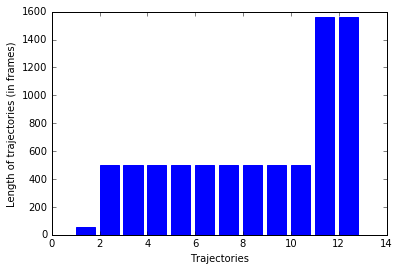

2016-06-30 13:49:50,674 - htmd.metricdata - INFO - Dropped 4 trajectories from 13 resulting in 9


/home/mariona/miniconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
2016-06-30 13:49:54,845 - htmd.metricdata - INFO - Mergesmall removed 55 clusters. Original ncluster 63, new ncluster 8.


30-06-16 13:49:55 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[6] WARNING  Changed user setting nits to the number of available timescales nits=7


2016-06-30 13:49:55,341 - pyemma.msm.estimators.implied_timescales.ImpliedTimescales[6] - WARNING - Changed user setting nits to the number of available timescales nits=7


30-06-16 13:49:55 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[6] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


2016-06-30 13:49:55,344 - pyemma.msm.estimators.implied_timescales.ImpliedTimescales[6] - WARNING - Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


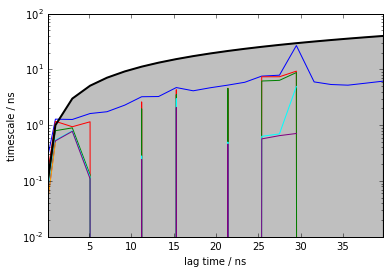







At which time do time scales converge?4
How many different time scales do you see?2


2016-06-30 13:51:32,970 - htmd.model - INFO - 99.5% of the data was used
2016-06-30 13:51:32,973 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2016-06-30 13:51:32,973 - htmd.model - INFO - [2 7]
2016-06-30 13:51:32,975 - htmd.model - INFO - Take care! Macro 0 has been visited only in 2 trajectories:
2016-06-30 13:51:32,976 - htmd.model - INFO - id = 3
parent = None
input = []
trajectory = ['./choline_adaptative_sampling/filtered/4/output.filtered.xtc']
molfile = ./choline_adaptative_sampling/filtered//filtered.pdb
2016-06-30 13:51:32,977 - htmd.model - INFO - id = 4
parent = None
input = []
trajectory = ['./choline_adaptative_sampling/filtered/5/output.filtered.xtc']
molfile = ./choline_adaptative_sampling/filtered//filtered.pdb
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   1 tasks  


 ########################################################## 

 Trajectories are to small. Starting analysis for next folder.

 ########################################################## 




========== Current ligand directory: ./ethanol_adaptative_sampling/filtered/  ==========

['./ethanol_adaptative_sampling/filtered/1/', './ethanol_adaptative_sampling/filtered/2/', './ethanol_adaptative_sampling/filtered/3/', './ethanol_adaptative_sampling/filtered/4/', './ethanol_adaptative_sampling/filtered/5/', './ethanol_adaptative_sampling/filtered/e1s1_1/', './ethanol_adaptative_sampling/filtered/e2s1_4p0f5/', './ethanol_adaptative_sampling/filtered/e2s2_5p0f357/', './ethanol_adaptative_sampling/filtered/e2s3_5p0f10/', './ethanol_adaptative_sampling/filtered/e2s4_5p0f349/', './ethanol_adaptative_sampling/filtered/e2s5_2p0f410/', './ethanol_adaptative_sampling/filtered/e2s6_3p0f184/', './ethanol_adaptative_sampling/filtered/e2s7_2p0f35/', './ethanol_adaptative_sampling/filtered/e3s1_5p0f85/',

2016-06-30 13:51:43,288 - htmd.simlist - INFO - Finished listing of simulations.


2016-06-30 13:51:43,635 - htmd.projections.metric - INFO - Metric: Starting projection of trajectories.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 

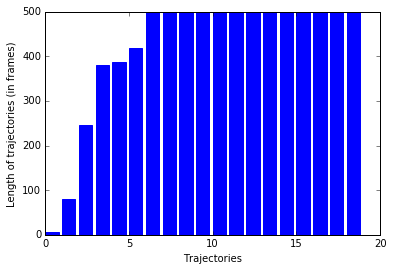

2016-06-30 13:51:48,613 - htmd.metricdata - INFO - Dropped 6 trajectories from 19 resulting in 13


/home/mariona/miniconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1300: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
2016-06-30 13:51:51,220 - htmd.metricdata - INFO - Mergesmall removed 533 clusters. Original ncluster 577, new ncluster 44.



 ########################################################## 

 Trajectories are to small. Starting analysis for next folder.

 ########################################################## 



In [4]:
%pylab inline
all_molecules=list()
all_dir=glob('./*_sampling/filtered/')
for directory in all_dir:
    print("\n\n\n========== Current ligand directory:",directory," ==========\n")
    try:
        print(glob(directory+'*/'), glob(directory+'/filtered.pdb'))
        sims = simlist(glob(directory+'*/'), glob(directory+'/filtered.pdb'))
        all_molecules.append(analysis(sims,boot=0.8,clusters=1000,merge=5)) 
    except:
        print('\n ########################################################## \n\n Trajectories are to small. Starting analysis for next folder.\n\n ########################################################## \n')
        continue

In [ ]:
print(all_molecules)